In [1]:
#Import Libraries
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
import string
import plotly.express as px
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('vader_lexicon')

!pip install unidecode
import unidecode

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
     |████████████████████████████████| 235 kB 7.1 MB/s 


In [2]:
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
import matplotlib.animation as animation
import operator
from collections import Counter

def dfCleaning(df):

    #import pandas_profiling

    #df = df[['text','retweet_count','favorite_count']]
    df.drop_duplicates(inplace = True)
    #Lowercase
    df['clean_tweet']= df['text'].apply(lambda x : x.lower())
    #Code to remove https
    df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    #Code to remove @
    df['clean_tweet'] = df['clean_tweet'].apply(
        lambda x : ' '.join([tweet for tweet in x.split()if not tweet.startswith("@")]))
    #Removing numbers
    df['clean_tweet'] = df['clean_tweet'].apply(
        lambda x : ' '.join([tweet for tweet in x.split() if not tweet == '\d*']))
    #Removing all the greek characters using unidecode library
    df['clean_tweet'] = df['clean_tweet'].apply(
        lambda x : ' '.join([unidecode.unidecode(word) for word in x.split()])) 
    #Removing the word 'hmm' and it's variants
    df['clean_tweet'] = df['clean_tweet'].apply(
        lambda x : ' '.join([word for word in x.split() if not word == 'h(m)+' ]))
    #Code for removing slang words
    d = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
                   'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother',
                   'cud':'could','fud':'food','gal':'girl'} ## Need a huge dictionary
    words = "I luv myself"
    words = words.split()
    reformed = [d[word] if word in d else word for word in words]
    reformed = " ".join(reformed)
    
    df['clean_tweet'] = df['clean_tweet'].apply(
        lambda x : ' '.join(d[word] if word in d else word for word in x.split()))
    
    #Finding words with # attached to it
    df['#'] = df['clean_tweet'].apply(
        lambda x : ' '.join([word for word in x.split() if word.startswith('#')]))
    frame = df['#']
    frame = pd.DataFrame(frame)
    frame = frame.rename({'#':'Count(#)'},axis = 'columns')
    frame[frame['Count(#)'] == ''] = 'No hashtags'
    data_frame = pd.concat([df,frame],axis = 1)
    data_frame.drop('#',axis = 1,inplace = True)
    
    #Column showing whether the corresponding tweet has a hash tagged word or not
    data_frame = data_frame.rename({'Count(#)':'Hash words'},axis = 'columns')

    #Removing stopwords
    data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(
        lambda x : ' '.join([word for word in x.split() 
                             if word not in set(stopwords.words('english')) and len(word) > 3]))
    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    #data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(
        lambda x : ' '.join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in nltk.pos_tag(x.split())]))

    #Code to remove punctuation
    data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : re.sub('[%s]' % re.escape(string.punctuation),'',str(x)))
    
    #Stemming
    #ps = PorterStemmer()
    #adwait = data_frame
    #data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : ' '.join([ps.stem(word) for word in x.split()]))
    #reset index
    data_frame.reset_index(drop=True, inplace=True)
        
    return data_frame

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
#Load EU data
data_path ="https://docs.google.com/spreadsheets/d/e/2PACX-1vS2YUVs3KiWrlRwhB5lChvWFcXohM2rCadmPQ6o9M8xqVVuyR8get446v5S8aLMTFyPbgelgoZpfJZK/pub?output=csv"
EU_df = pd.read_csv(data_path)
EU_df.shape

(1878, 151)

In [5]:
#Load NA data
data_path ="https://docs.google.com/spreadsheets/d/e/2PACX-1vShLH35WobPiO9SfKXExN_DTiW7iiBMM1zWJ5rFAJXKaaqvMlSLUqhdlIvDFByy7kayfpZ1LbrMq--0/pub?output=csv"
NA_df = pd.read_csv(data_path)
NA_df.shape

(626, 149)

In [6]:
#Load Asia data
data_path ="https://docs.google.com/spreadsheets/d/e/2PACX-1vRmG40vTMYS1mYPBZoYl0ZvEAQOShKEiT0pCS90Pxk7K6pzKUPDEHtt6FvpJ5TJOATJTSw7quKs9_IW/pub?output=csv"
AS_df = pd.read_csv(data_path)
AS_df.shape

(106, 153)

In [7]:
#Load India data
data_path ="https://docs.google.com/spreadsheets/d/e/2PACX-1vRzAc7Qjdm30l52Z3HwxOXemjXYYvRYNgloyVlXO_JP07PtxjwGJj56dt4Hvk6gCkvn0vAF5GxyH1wQ/pub?output=csv"
IN_df = pd.read_csv(data_path)
IN_df.shape

(309, 153)

**Europe Data**

In [8]:
EU_df.info()
EU_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1878 entries, 0 to 1877
Columns: 151 entries, _id to user.withheld_in_countries
dtypes: bool(18), float64(37), int64(9), object(87)
memory usage: 1.9+ MB


,_id,contributors,coordinates,created_at,entities.hashtags,entities.media,entities.symbols,entities.urls,entities.user_mentions,extended_entities.media,favorite_count,favorited,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,metadata.iso_language_code,metadata.result_type,place,possibly_sensitive,quoted_status.contributors,quoted_status.coordinates,quoted_status.created_at,quoted_status.entities.hashtags,quoted_status.entities.media,quoted_status.entities.symbols,quoted_status.entities.urls,quoted_status.entities.user_mentions,quoted_status.extended_entities.media,quoted_status.favorite_count,quoted_status.favorited,quoted_status.geo,quoted_status.id,quoted_status.id_str,...,user.description,user.entities.description.urls,user.entities.url.urls,user.favourites_count,user.follow_request_sent,user.followers_count,user.following,user.friends_count,user.geo_enabled,user.has_extended_profile,user.id,user.id_str,user.is_translation_enabled,user.is_translator,user.lang,user.listed_count,user.location,user.name,user.notifications,user.profile_background_color,user.profile_background_image_url,user.profile_background_image_url_https,user.profile_background_tile,user.profile_banner_url,user.profile_image_url,user.profile_image_url_https,user.profile_link_color,user.profile_sidebar_border_color,user.profile_sidebar_fill_color,user.profile_text_color,user.profile_use_background_image,user.protected,user.screen_name,user.statuses_count,user.time_zone,user.translator_type,user.url,user.utc_offset,user.verified,user.withheld_in_countries
0,61edc79d9130aa71fc8397a7,NaN,NaN,Sun Jan 23 21:23:07 +0000 2022,[],NaN,[],"[{""url"":""https://t.co/QosYCVUKkL"",""expanded_ur...",[],NaN,3,False,NaN,1.485362e+18,1.485362e+18,NaN,NaN,NaN,NaN,NaN,False,en,en,recent,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Sexual violence survivor. Women’s rights campa...,"[{""url"":""https://t.co/996of7bQIT"",""expanded_ur...",NaN,1757,False,2233,False,876,False,True,1464925171056357376,1464925171056357376,False,False,NaN,3,East Sussex,Sarah,False,F5F8FA,NaN,NaN,False,https://pbs.twimg.com/profile_banners/14649251...,http://pbs.twimg.com/profile_images/1464925889...,https://pbs.twimg.com/profile_images/146492588...,1DA1F2,C0DEED,DDEEF6,333333,True,False,SarahSurviving,303,NaN,none,NaN,NaN,False,[]
1,61edc79d9130aa71fc8397a8,NaN,NaN,Sun Jan 23 21:20:00 +0000 2022,[],NaN,[],"[{""url"":""https://t.co/TFwAllXenO"",""expanded_ur...",[],NaN,1,False,NaN,1.485362e+18,1.485362e+18,NaN,NaN,NaN,NaN,NaN,False,en,en,recent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Social Entrepreneur|Businesswoman|Equalities C...,[],"[{""url"":""https://t.co/gzvq6wbmVP"",""expanded_ur...",21188,False,9127,False,2962,True,True,32610083,32610083,False,False,NaN,152,London,Akeela Ahmed MBE,False,C0DEED,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,https://pbs.twimg.com/profile_banners/32610083...,http://pbs.twimg.com/profile_images/1072526677...,https://pbs.twimg.com/profile_images/107252667...,1DA1F2,C0DEED,DDEEF6,333333,True,False,AkeelaAhmed,59134,NaN,none,https://t.co/gzvq6wbmVP,NaN,False,[]
2,61edc79d9130aa71fc8397a9,NaN,NaN,Sun Jan 23 21:18:20 +0000 2022,[],NaN,[],[],"[{""screen_name"":""GeorgeHotchki14"",""name"":""Geor...",NaN,0,False,NaN,1.485361e+18,1.485361e+18,GeorgeHotchki14,1.485349e+18,1.485349e+18,1.371082e+18,1.371082e+18,False,en,en,recent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"‘Woman’ is not a costume, feeling or desire bu...",[],NaN,75485,False,7148,False,5512,False,False,2187253405,2187253405,False,False,NaN,38,York,Ulrike Bullerby,False,C0DEED,http://abs.twimg.com/images/themes/theme1/bg.png,https://abs.twimg.com/images/themes/theme1/bg.png,False,https://pbs.twimg.com/profile_banners/21872534...,http://pbs.twimg.com/profile_images/1473580772

In [9]:
EU_tweets = EU_df[['text','retweet_count','favorite_count']]

In [10]:
#Data cleaning
EU_Cleaned = dfCleaning(EU_tweets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [11]:
EU_Cleaned.head()

,text,retweet_count,favorite_count,clean_tweet,Hash words
0,A women’s support group chooses not to signpos...,2,3,womens support group choose signpost vulnerabl...,No hashtags
1,You know the worst thing about the hate incide...,0,1,know bad thing hate incident experience last w...,No hashtags
2,"@GeorgeHotchki14 @HJoyceGender @amscanlon Yup,...",0,0,yup misogyny hate crime scotland course,No hashtags
3,@peacelove1967 @ScotCuthbertson Started report...,0,0,start report trust source switchboard amp lgbt...,No hashtags
4,@peacelove1967 @ScotCuthbertson You talk of mu...,0,0,talk muddy water whilst deliberately misinterp...,No hashtags


**North America Data**

In [12]:
NA_tweets = NA_df[['text','retweet_count','favorite_count']]

In [13]:
NA_Cleaned = dfCleaning(NA_tweets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [14]:
NA_Cleaned.head()

,text,retweet_count,favorite_count,clean_tweet,Hash words
0,@TheRevAl @TheRevAl @MeetThePress @FaceTheNati...,1,1,white black americans v,No hashtags
1,@nathaliejacoby1 the legal punishment will not...,0,7,legal punishment strong enough sure criminal c...,No hashtags
2,Cooper Kupp out there cookin Niggas like its ...,0,1,cooper kupp cookin nigga like hate crime,No hashtags
3,@angry_gammy @thatdaneshguy Absolutely its a h...,0,0,absolutely hate crime,No hashtags
4,"@PR_NHL What about racism to white people, we ...",0,0,racism white people label every race attack ra...,No hashtags


**Asia Data**

In [15]:
AS_tweets = AS_df[['text','retweet_count','favorite_count']]

In [16]:
AS_Cleaned = dfCleaning(AS_tweets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [17]:
AS_Cleaned.head()

,text,retweet_count,favorite_count,clean_tweet,Hash words
0,District attorney of Connecticut: James be cha...,0,0,district attorney connecticut james charge hat...,No hashtags
1,@hongerootooties this is a hate crime cc: @ril...,0,0,hate crime,No hashtags
2,@k_athanasi @FrankPallone Your tweet is a HATE...,0,0,tweet hate crime,No hashtags
3,This is a hate crime https://t.co/Zzfvrvjmft,0,1,hate crime,No hashtags
4,@legendaryadkins this is hate crime,0,0,hate crime,No hashtags


**India Data**

In [18]:
IN_tweets = IN_df[['text','retweet_count','favorite_count']]

In [19]:
IN_Cleaned = dfCleaning(IN_tweets)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [20]:
IN_Cleaned.head()

,text,retweet_count,favorite_count,clean_tweet,Hash words
0,@Hate_Congress @AminaaKausar Death sentence fo...,0,0,death sentence heinous crime religion matter s...,No hashtags
1,@Hate_Congress @AminaaKausar Crime is crime . ...,0,0,crime crime chayeee mere kareee apkeeee kanoon...,No hashtags
2,@DiwakarSharmaa @ShivRajMathur1 Now they are a...,0,1,criminals really disturb young generation consumi,No hashtags
3,"I hate this bitch, she'll befriend u, turn u t...",0,0,hate bitch shell befriend turn crime turn cops...,No hashtags
4,@FaissalFarooq @Nidhi What these guys ve alleg...,0,0,guy allegedly do sick amount cyber crime ampno...,No hashtags


**EDA**

*Tweet Count*

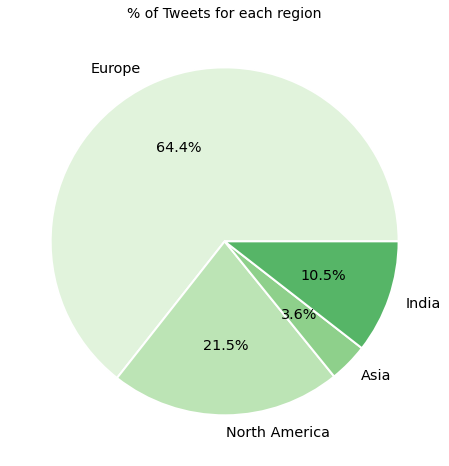

In [24]:
#count the total tweets of each dataframe
dataframes = {'Europe': EU_Cleaned, 'North America': NA_Cleaned, 'Asia': AS_Cleaned, 'India': IN_Cleaned}
df_region = pd.DataFrame([(i, df.shape[0]) for i, df in dataframes.items()],
                            columns=['df','count_rows'])

#tweets for each region_plot
fig, ax = plt.subplots(figsize=(12,8))

labels = df_region['df']
colors = sns.color_palette("Greens")

ax.pie(df_region['count_rows'], labels=labels, colors=colors, autopct='%.1f%%',
       wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},
       textprops={'size': 'x-large'})
ax.set_title('% of Tweets for each region', fontsize=14)

plt.show()

*Retweet Count*

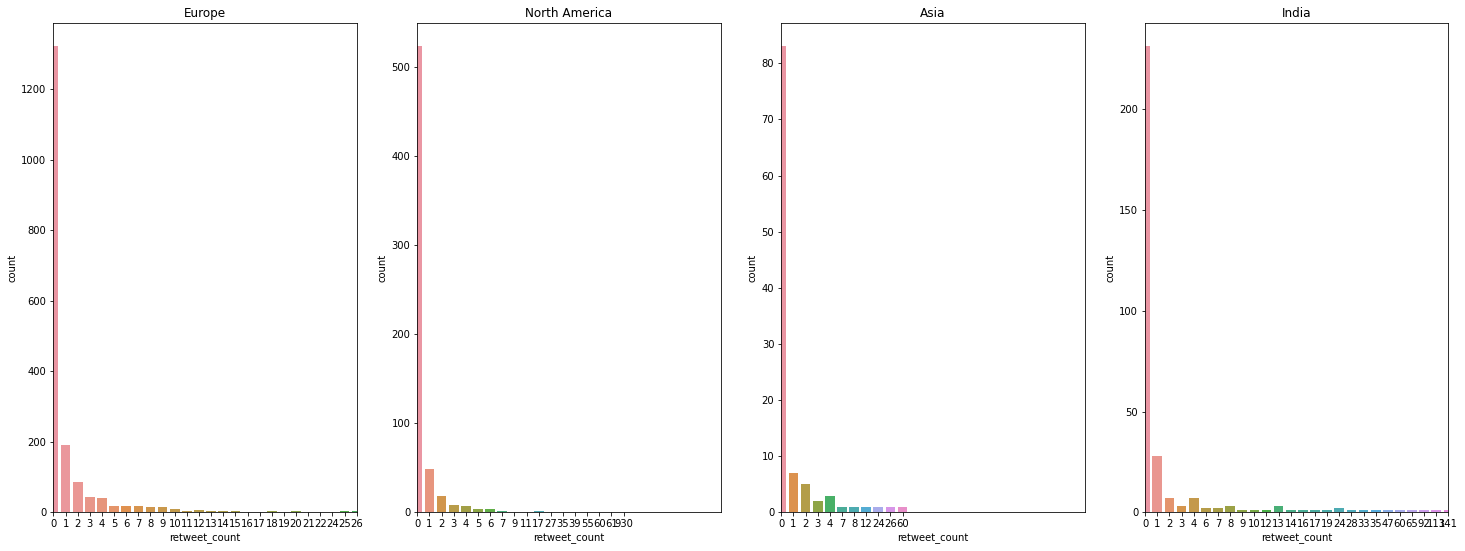

In [22]:
#retweet_count plots
fig, axs = plt.subplots(1,4, figsize=(25,9))

ax1=sns.countplot(x='retweet_count', data=EU_Cleaned, ax=axs[0])
ax1.set(title='Europe')
ax1.set_xlim([0, 25])

ax2=sns.countplot(x='retweet_count', data=NA_Cleaned, ax=axs[1])
ax2.set(title='North America')
ax2.set_xlim([0, 25])

ax3=sns.countplot(x='retweet_count', data=AS_Cleaned, ax=axs[2])
ax3.set(title='Asia')
ax3.set_xlim([0, 25])

ax4=sns.countplot(x='retweet_count', data=IN_Cleaned, ax=axs[3])
ax4.set(title='India')
ax4.set_xlim([0, 25])

plt.show()

*Favorite Count*

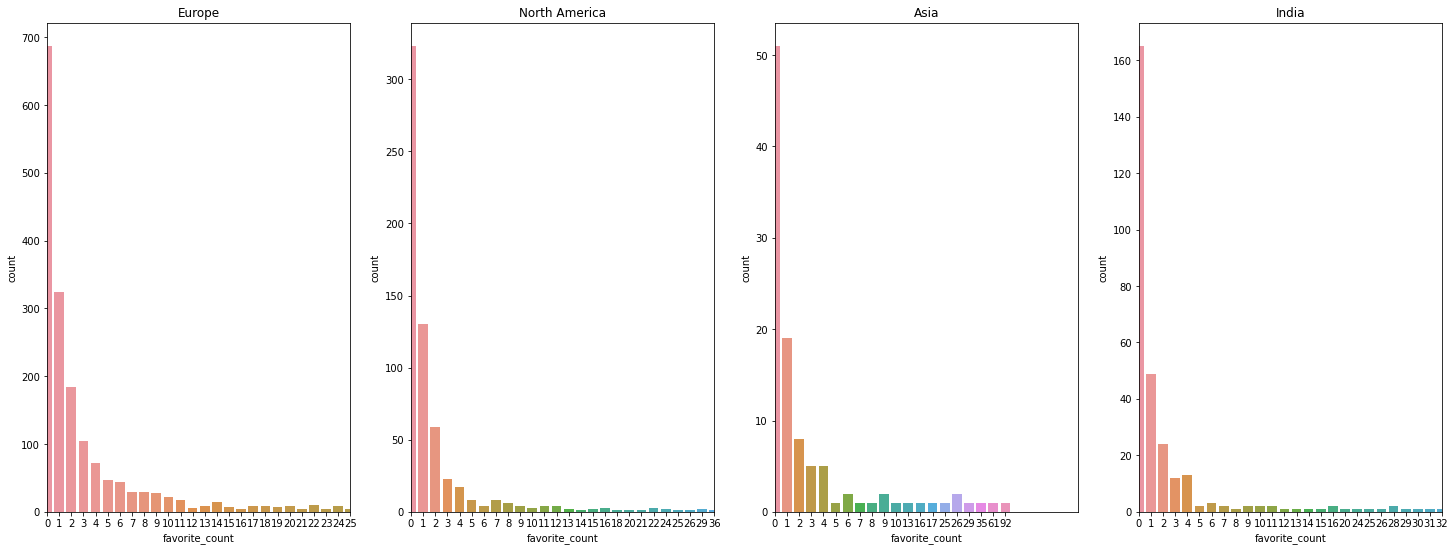

In [23]:
#favorite_count plots
fig, axs = plt.subplots(1,4, figsize=(25,9))

ax1=sns.countplot(x='favorite_count', data=EU_Cleaned, ax=axs[0])
ax1.set(title='Europe')
ax1.set_xlim([0, 25])

ax2=sns.countplot(x='favorite_count', data=NA_Cleaned, ax=axs[1])
ax2.set(title='North America')
ax2.set_xlim([0, 25])

ax3=sns.countplot(x='favorite_count', data=AS_Cleaned, ax=axs[2])
ax3.set(title='Asia')
ax3.set_xlim([0, 25])

ax4=sns.countplot(x='favorite_count', data=IN_Cleaned, ax=axs[3])
ax4.set(title='India')
ax4.set_xlim([0, 25])

plt.show()

**Most Common Words**

*EU*

In [25]:
#Most common words
EU_Cleaned['temp_list'] = EU_Cleaned['clean_tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in EU_Cleaned['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
0,hate,1425
1,crime,1353
2,misogyny,399
3,make,277
4,lord,184
5,vote,166
6,report,125
7,defeat,110
8,police,109
9,people,105


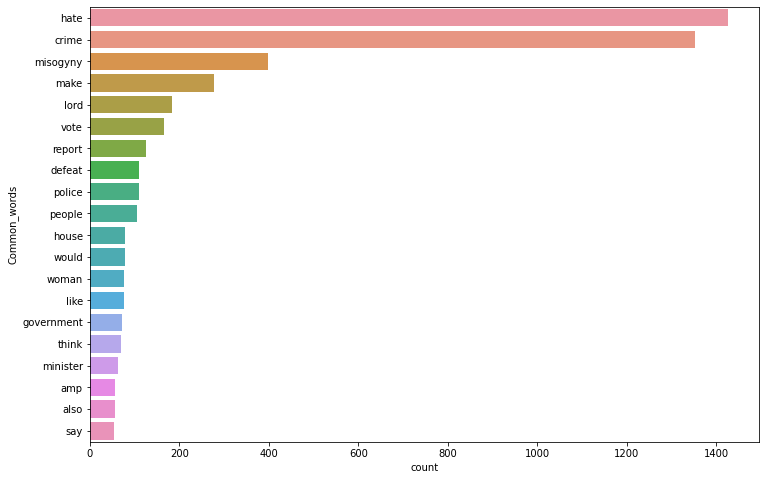

In [26]:
#Bar plot for most common words
plt.figure(figsize=(12,8))
sns.barplot(y='Common_words', x='count', data=temp)

*NA*

In [27]:
#Most common words
NA_Cleaned['temp_list'] = NA_Cleaned['clean_tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in NA_Cleaned['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
0,crime,408
1,hate,403
2,asian,43
3,like,41
4,woman,38
5,charge,34
6,attack,32
7,call,30
8,hostage,29
9,people,28


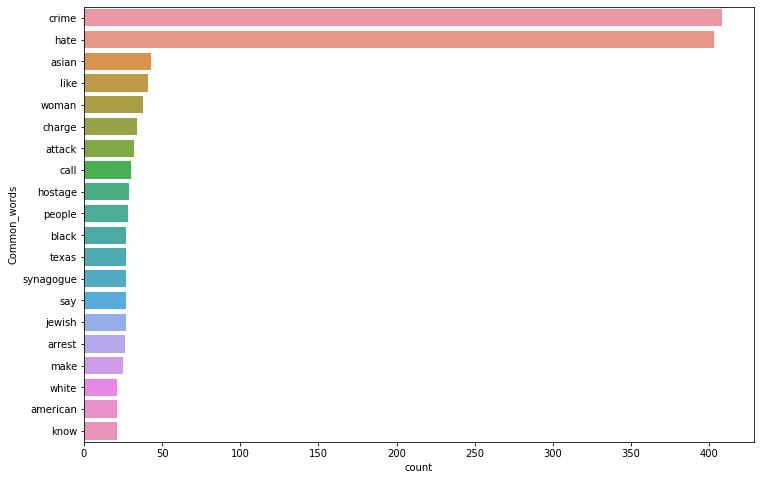

In [28]:
#Bar plot for most common words
plt.figure(figsize=(12,8))
sns.barplot(y='Common_words', x='count', data=temp)

*AS*

In [29]:
#Most common words
AS_Cleaned['temp_list'] = AS_Cleaned['clean_tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in AS_Cleaned['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
0,hate,84
1,crime,79
2,asian,17
3,people,9
4,make,7
5,stop,6
6,commit,6
7,black,6
8,like,5
9,know,5


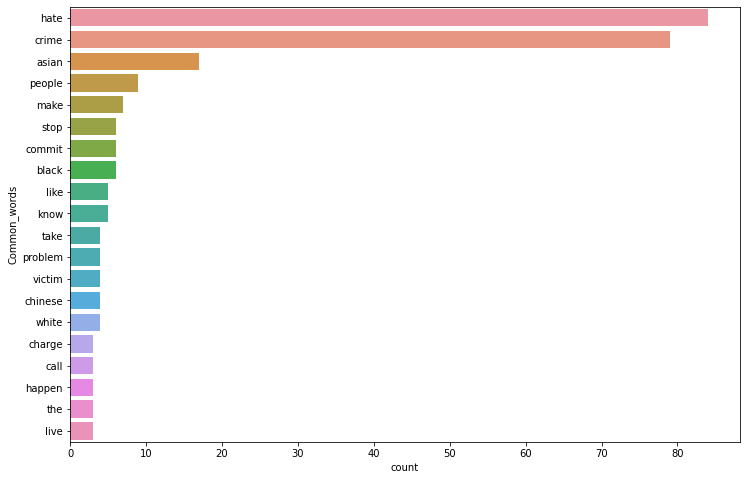

In [30]:
#Bar plot for most common words
plt.figure(figsize=(12,8))
sns.barplot(y='Common_words', x='count', data=temp)

*IN*

In [31]:
#Most common words
IN_Cleaned['temp_list'] = IN_Cleaned['clean_tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in IN_Cleaned['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
0,hate,213
1,crime,209
2,sikh,34
3,make,27
4,taxi,25
5,driver,25
6,arrest,24
7,attack,24
8,muslim,20
9,charge,18


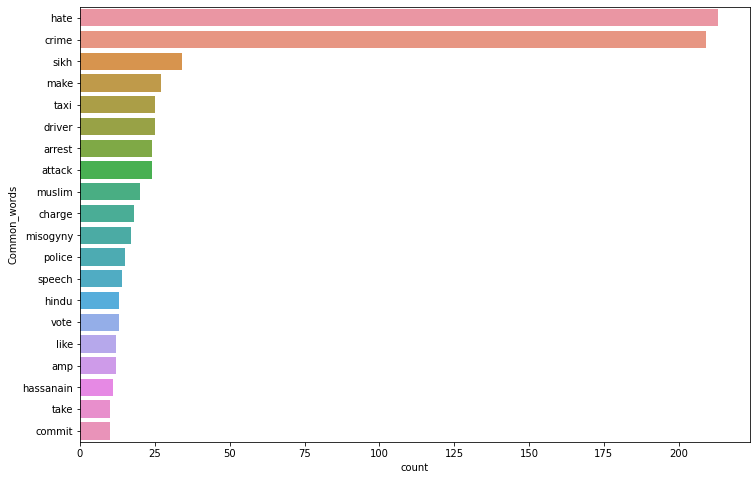

In [32]:
#Bar plot for most common words
plt.figure(figsize=(12,8))
sns.barplot(y='Common_words', x='count', data=temp)

**Wordclouds**

In [33]:
def my_tf_color_func(dictionary):
  def my_tf_color_func_inner(word, **kwargs):
    return "hsl(%d, 80%%, 50%%)" % (360 * dictionary[word])
  return my_tf_color_func_inner

*EU*

Normal words


(-0.5, 799.5, 499.5, -0.5)

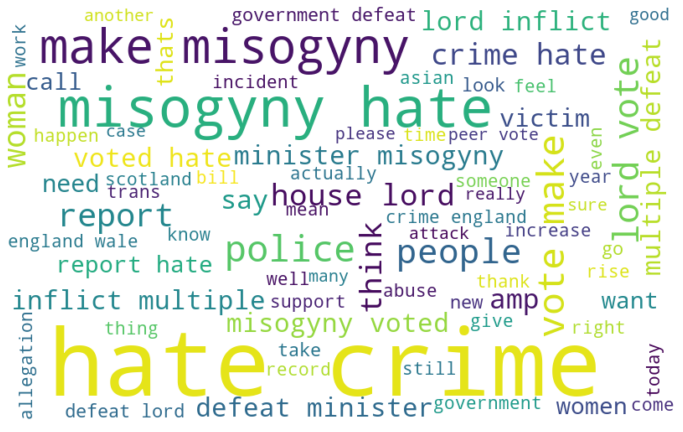

In [34]:
normal_words = ' '.join([word for word in EU_Cleaned['clean_tweet']])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 75,background_color = "white").generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

EU Hashtags

hashtags


(-0.5, 799.5, 499.5, -0.5)

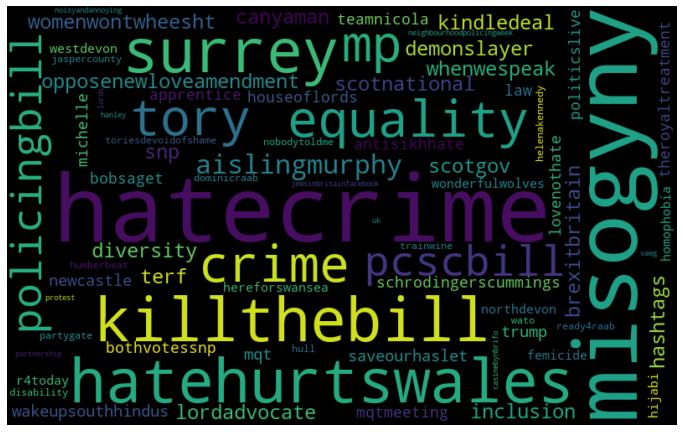

In [48]:
hashtags = ' '.join([word for word in EU_Cleaned['Hash words'].unique()])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 75,background_color = "black").generate(hashtags)
print('hashtags')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear', cmap='Set2')
plt.axis('off')

*NA*

Normal words


(-0.5, 799.5, 499.5, -0.5)

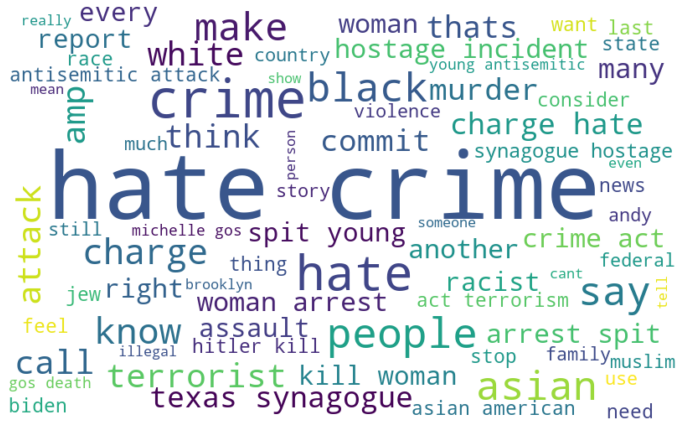

In [49]:
normal_words = ' '.join([word for word in NA_Cleaned['clean_tweet']])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 75,background_color = "white").generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

NA Hashtags

hashtags


(-0.5, 799.5, 499.5, -0.5)

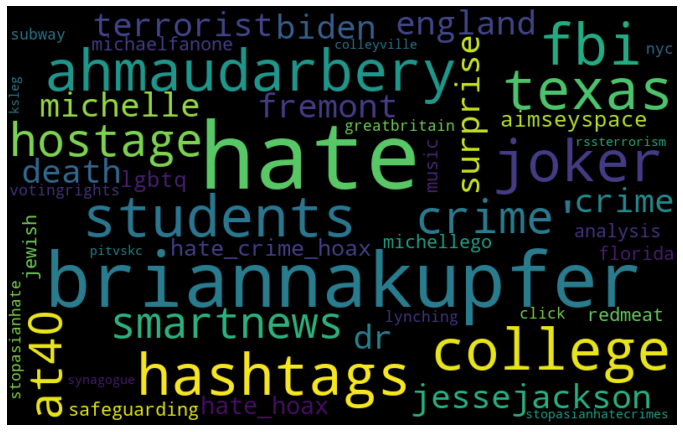

In [50]:
hashtags = ' '.join([word for word in NA_Cleaned['Hash words'].unique()])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 75,background_color = "black").generate(hashtags)
print('hashtags')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='Set2')
plt.axis('off')

*AS*

Normal words


(-0.5, 799.5, 499.5, -0.5)

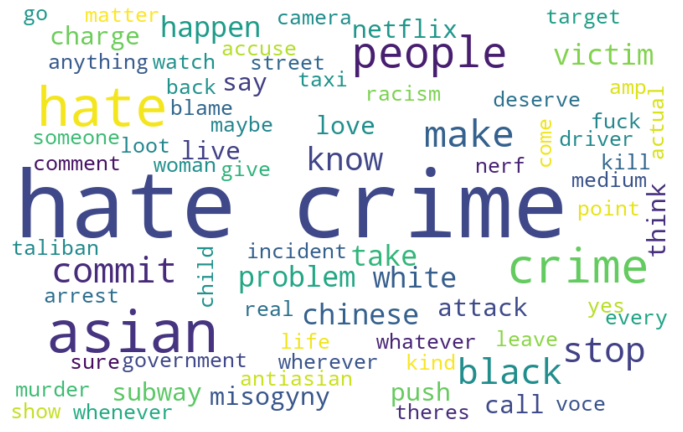

In [51]:
normal_words = ' '.join([word for word in AS_Cleaned['clean_tweet']])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 75,background_color = "white").generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

AS Hashtags

hashtags


(-0.5, 799.5, 499.5, -0.5)

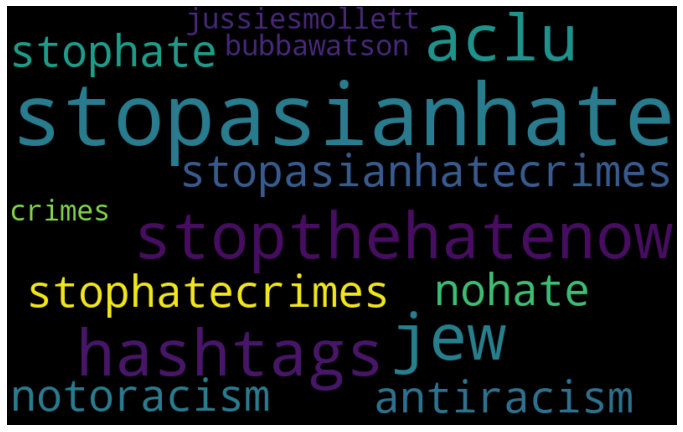

In [52]:
hashtags = ' '.join([word for word in AS_Cleaned['Hash words'].unique()])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 75,background_color = "black").generate(hashtags)
print('hashtags')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='Set2')
plt.axis('off')

*IN*

Normal words


(-0.5, 799.5, 499.5, -0.5)

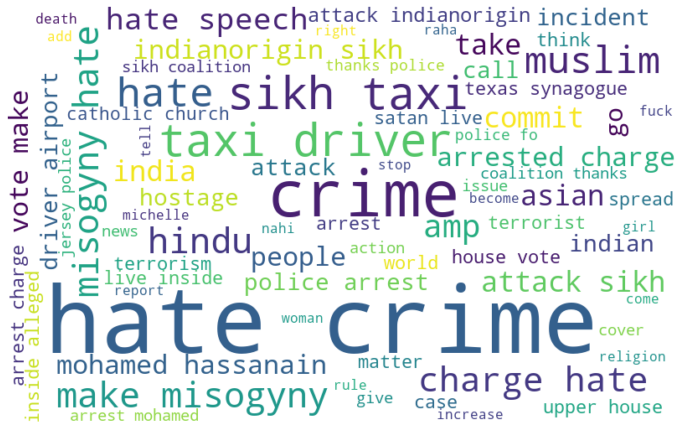

In [53]:
normal_words = ' '.join([word for word in IN_Cleaned['clean_tweet']])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 75,background_color = "white").generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

IN Hashtags

hashtags


(-0.5, 799.5, 499.5, -0.5)

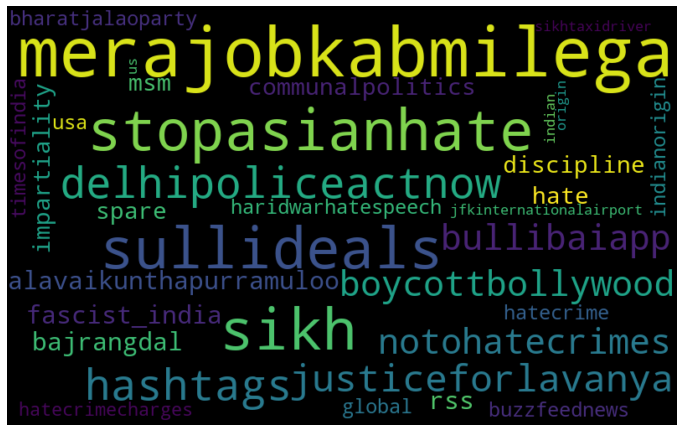

In [54]:
hashtags = ' '.join([word for word in IN_Cleaned['Hash words'].unique()])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 75,background_color = "black").generate(hashtags)
print('hashtags')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='Set2')
plt.axis('off')

**Vader Sentiment Analysis**
- polarity
- subjectivity
- neg, neu, pos scores
- compound
-sentiment

*Europe*

In [67]:
#Europe
sia = SentimentIntensityAnalyzer()
EU_Cleaned[['polarity', 'subjectivity']] = EU_Cleaned['clean_tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, s in enumerate(EU_Cleaned['text']):
  ps = sia.polarity_scores(s)
  EU_Cleaned.loc[index,['neg']] = ps['neg']
  EU_Cleaned.loc[index,['neu']] = ps['neu']
  EU_Cleaned.loc[index,['pos']] = ps['pos']
  EU_Cleaned.loc[index,['compound']] = ps['compound']
  if ps['neg'] > ps['pos']:
    EU_Cleaned.loc[index,['sentiment']] = 'negative'
  elif ps['pos'] > ps['neg']:
    EU_Cleaned.loc[index,['sentiment']] = 'positive'
  else:
    EU_Cleaned.loc[index,['sentiment']] = 'neutral'
   
EU_Cleaned.head(10)

,text,retweet_count,favorite_count,clean_tweet,Hash words,temp_list,polarity,subjectivity,neg,neu,pos,compound,sentiment
0,A women’s support group chooses not to signpos...,2,3,womens support group choose signpost vulnerabl...,No hashtags,"[womens, support, group, choose, signpost, vul...",-0.250000,0.300000,0.188,0.638,0.174,-0.3257,negative
1,You know the worst thing about the hate incide...,0,1,know bad thing hate incident experience last w...,No hashtags,"[know, bad, thing, hate, incident, experience,...",-0.500000,0.544444,0.339,0.607,0.054,-0.8402,negative
2,"@GeorgeHotchki14 @HJoyceGender @amscanlon Yup,...",0,0,yup misogyny hate crime scotland course,No hashtags,"[yup, misogyny, hate, crime, scotland, course]",-0.800000,0.900000,0.324,0.676,0.000,-0.8020,negative
3,@peacelove1967 @ScotCuthbertson Started report...,0,0,start report trust source switchboard amp lgbt...,No hashtags,"[start, report, trust, source, switchboard, am...",0.000000,0.000000,0.000,0.819,0.181,0.4767,positive
4,@peacelove1967 @ScotCuthbertson You talk of mu...,0,0,talk muddy water whilst deliberately misinterp...,No hashtags,"[talk, muddy, water, whilst, deliberately, mis...",-0.800000,0.900000,0.209,0.791,0.000,-0.5719,negative
5,@AntisemitismEye @NoughtFollowers @ayeshahazar...,0,0,douglas murray spectator hardly advocat,No hashtags,"[douglas, murray, spectator, hardly, advocat]",-0.291667,0.541667,0.000,1.000,0.000,0.0000,neutral
6,@HJoyceGender @amscanlon Reporting this as a h...,0,5,report hate crime seem constitute hate crime f...,No hashtags,"[report, hate, crime, seem, constitute, hate, ...",-0.800000,0.900000,0.490,0.510,0.000,-0.9371,negative
7,Awful news that a gay man has been the victim ...,1,4,awful news victim hate crime sincerely hope ab...,No hashtags,"[awful, news, victim, hate, crime, sincerely, ...",-0.175000,0.615000,0.369,0.450,0.180,-0.7430,negative
8,The transphobes don’t care about the soaring h...,14,66,transphobes care soar hate crime statistics ke...,No hashtags,"[transphobes, care, soar, hate, crime, statist...",-0.800000,0.900000,0.375,0.515,0.110,-0.8271,negative
9,@FootyBevs @FootyScran @ManUtd This is a hate ...,0,0,hate crime,No hashtags,"[hate, crime]",-0.800000,0.900000,0.590,0.410,0.000,-0.8020,negative


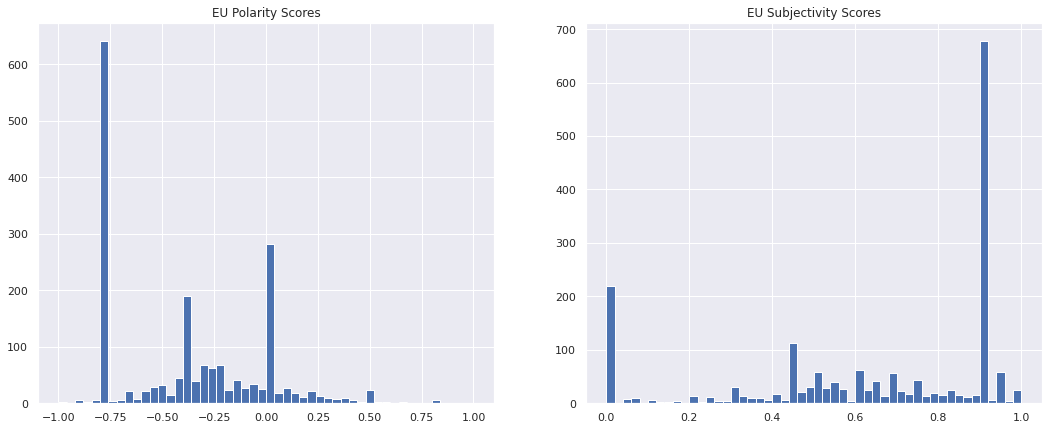

In [68]:
#EU Histograms of polarity and subjectivity
n_bins = 50
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(EU_Cleaned["polarity"], bins = n_bins)
ax1.set_title('EU Polarity Scores')
ax2.hist(EU_Cleaned["subjectivity"], bins = n_bins)
ax2.set_title('EU Subjectivity Scores')
plt.show()

[Text(0.5, 0, 'Europe Sentiment Result')]

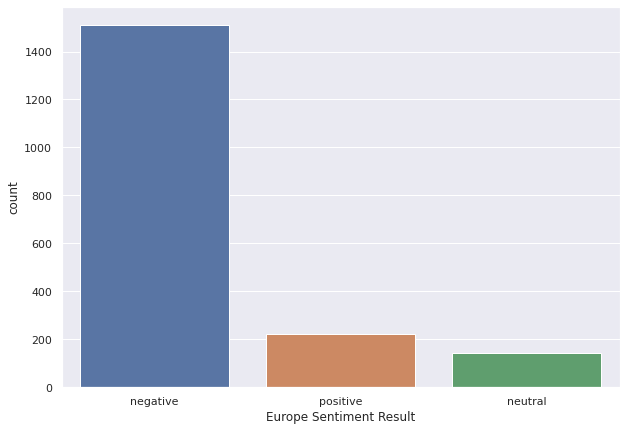

In [69]:
#EU Countplot of sentiment
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="sentiment", data=EU_Cleaned)
ax.set(xlabel='Europe Sentiment Result')

*North Amercia*

In [70]:
#North America
sia = SentimentIntensityAnalyzer()
NA_Cleaned[['polarity', 'subjectivity']] = NA_Cleaned['clean_tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, s in enumerate(NA_Cleaned['text']):
  ps = sia.polarity_scores(s)
  NA_Cleaned.loc[index,['neg']] = ps['neg']
  NA_Cleaned.loc[index,['neu']] = ps['neu']
  NA_Cleaned.loc[index,['pos']] = ps['pos']
  NA_Cleaned.loc[index,['compound']] = ps['compound']
  if ps['neg'] > ps['pos']:
    NA_Cleaned.loc[index,['sentiment']] = 'negative'
  elif ps['pos'] > ps['neg']:
    NA_Cleaned.loc[index,['sentiment']] = 'positive'
  else:
    NA_Cleaned.loc[index,['sentiment']] = 'neutral'
   
NA_Cleaned.head()

,text,retweet_count,favorite_count,clean_tweet,Hash words,temp_list,polarity,subjectivity,neg,neu,pos,compound,sentiment
0,@TheRevAl @TheRevAl @MeetThePress @FaceTheNati...,1,1,white black americans v,No hashtags,"[white, black, americans, v]",-0.083333,0.216667,0.000,1.000,0.000,0.0000,neutral
1,@nathaliejacoby1 the legal punishment will not...,0,7,legal punishment strong enough sure criminal c...,No hashtags,"[legal, punishment, strong, enough, sure, crim...",0.146667,0.574444,0.302,0.562,0.136,-0.4299,negative
2,Cooper Kupp out there cookin Niggas like its ...,0,1,cooper kupp cookin nigga like hate crime,No hashtags,"[cooper, kupp, cookin, nigga, like, hate, crime]",-0.800000,0.900000,0.531,0.345,0.123,-0.8507,negative
3,@angry_gammy @thatdaneshguy Absolutely its a h...,0,0,absolutely hate crime,No hashtags,"[absolutely, hate, crime]",-0.800000,0.900000,0.675,0.325,0.000,-0.8529,negative
4,"@PR_NHL What about racism to white people, we ...",0,0,racism white people label every race attack ra...,No hashtags,"[racism, white, people, label, every, race, at...",0.000000,0.000000,0.262,0.738,0.000,-0.7964,negative


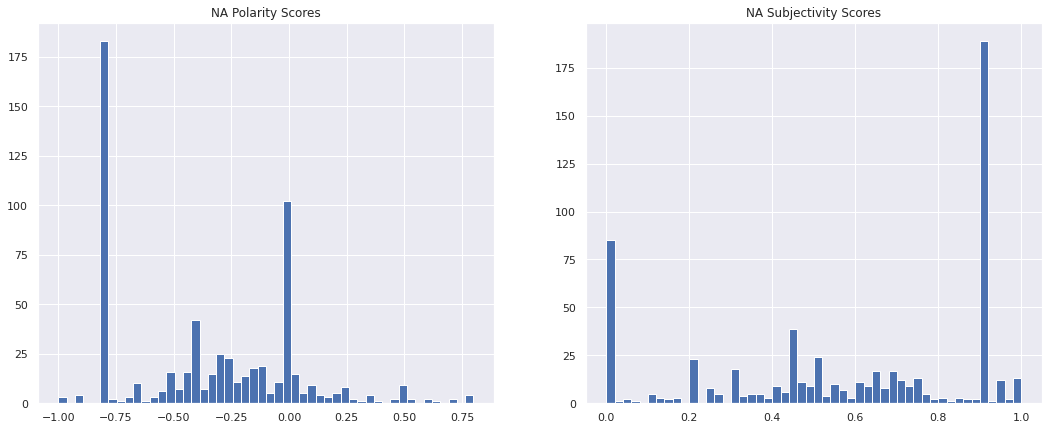

In [71]:
#NA Histograms of polarity and subjectivity
n_bins = 50
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(NA_Cleaned["polarity"], bins = n_bins)
ax1.set_title('NA Polarity Scores')
ax2.hist(NA_Cleaned["subjectivity"], bins = n_bins)
ax2.set_title('NA Subjectivity Scores')
plt.show()

[Text(0.5, 0, 'North America Sentiment Result')]

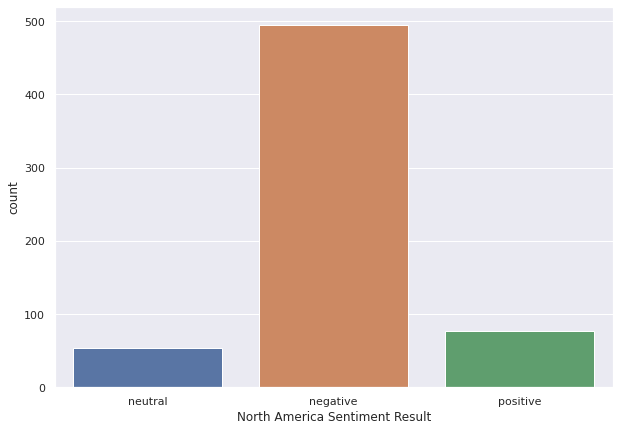

In [72]:
#NA Countplot of sentiment
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="sentiment", data=NA_Cleaned)
ax.set(xlabel='North America Sentiment Result')

*Asia*

In [73]:
#Asia
sia = SentimentIntensityAnalyzer()
AS_Cleaned[['polarity', 'subjectivity']] = AS_Cleaned['clean_tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, s in enumerate(AS_Cleaned['text']):
  ps = sia.polarity_scores(s)
  AS_Cleaned.loc[index,['neg']] = ps['neg']
  AS_Cleaned.loc[index,['neu']] = ps['neu']
  AS_Cleaned.loc[index,['pos']] = ps['pos']
  AS_Cleaned.loc[index,['compound']] = ps['compound']
  if ps['neg'] > ps['pos']:
    AS_Cleaned.loc[index,['sentiment']] = 'negative'
  elif ps['pos'] > ps['neg']:
    AS_Cleaned.loc[index,['sentiment']] = 'positive'
  else:
    AS_Cleaned.loc[index,['sentiment']] = 'neutral'
   
AS_Cleaned.head()

,text,retweet_count,favorite_count,clean_tweet,Hash words,temp_list,polarity,subjectivity,neg,neu,pos,compound,sentiment
0,District attorney of Connecticut: James be cha...,0,0,district attorney connecticut james charge hat...,No hashtags,"[district, attorney, connecticut, james, charg...",-0.8,0.9,0.417,0.583,0.0,-0.8516,negative
1,@hongerootooties this is a hate crime cc: @ril...,0,0,hate crime,No hashtags,"[hate, crime]",-0.8,0.9,0.590,0.410,0.0,-0.8020,negative
2,@k_athanasi @FrankPallone Your tweet is a HATE...,0,0,tweet hate crime,No hashtags,"[tweet, hate, crime]",-0.8,0.9,0.441,0.559,0.0,-0.6932,negative
3,This is a hate crime https://t.co/Zzfvrvjmft,0,1,hate crime,No hashtags,"[hate, crime]",-0.8,0.9,0.706,0.294,0.0,-0.8020,negative
4,@legendaryadkins this is hate crime,0,0,hate crime,No hashtags,"[hate, crime]",-0.8,0.9,0.706,0.294,0.0,-0.8020,negative


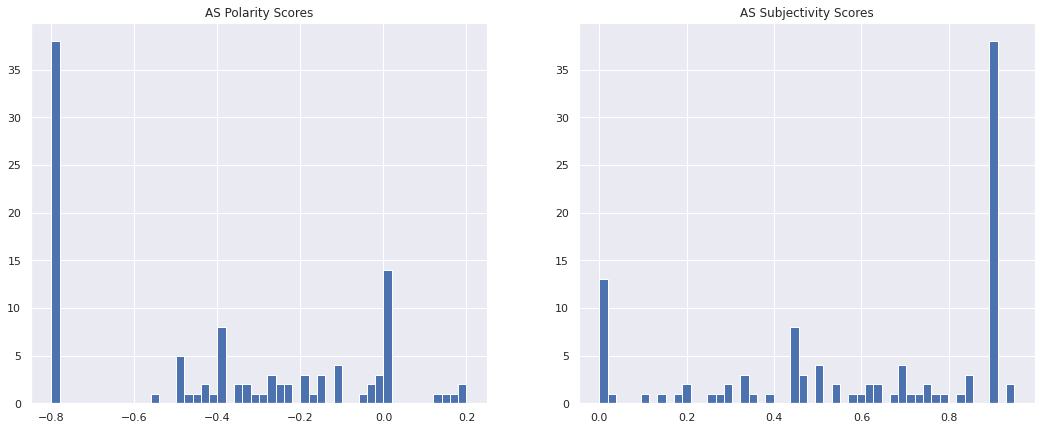

In [74]:
#AS Histograms of polarity and subjectivity
n_bins = 50
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(AS_Cleaned["polarity"], bins = n_bins)
ax1.set_title('AS Polarity Scores')
ax2.hist(AS_Cleaned["subjectivity"], bins = n_bins)
ax2.set_title('AS Subjectivity Scores')
plt.show()

[Text(0.5, 0, 'Asia Sentiment Result')]

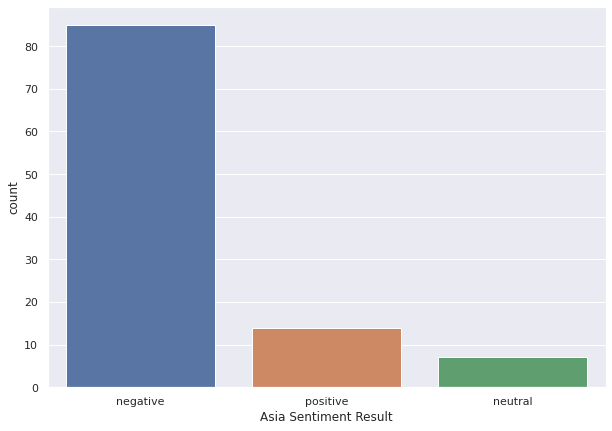

In [75]:
#AS Countplot of sentiment
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="sentiment", data=AS_Cleaned)
ax.set(xlabel='Asia Sentiment Result')

*India*

In [76]:
#India
sia = SentimentIntensityAnalyzer()
IN_Cleaned[['polarity', 'subjectivity']] = IN_Cleaned['clean_tweet'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, s in enumerate(IN_Cleaned['text']):
  ps = sia.polarity_scores(s)
  IN_Cleaned.loc[index,['neg']] = ps['neg']
  IN_Cleaned.loc[index,['neu']] = ps['neu']
  IN_Cleaned.loc[index,['pos']] = ps['pos']
  IN_Cleaned.loc[index,['compound']] = ps['compound']
  if ps['neg'] > ps['pos']:
    IN_Cleaned.loc[index,['sentiment']] = 'negative'
  elif ps['pos'] > ps['neg']:
    IN_Cleaned.loc[index,['sentiment']] = 'positive'
  else:
    IN_Cleaned.loc[index,['sentiment']] = 'neutral'
   
IN_Cleaned.head()

,text,retweet_count,favorite_count,clean_tweet,Hash words,temp_list,polarity,subjectivity,neg,neu,pos,compound,sentiment
0,@Hate_Congress @AminaaKausar Death sentence fo...,0,0,death sentence heinous crime religion matter s...,No hashtags,"[death, sentence, heinous, crime, religion, ma...",0.000000,0.000000,0.432,0.467,0.102,-0.8682,negative
1,@Hate_Congress @AminaaKausar Crime is crime . ...,0,0,crime crime chayeee mere kareee apkeeee kanoon...,No hashtags,"[crime, crime, chayeee, mere, kareee, apkeeee,...",-0.500000,0.500000,0.304,0.696,0.000,-0.7906,negative
2,@DiwakarSharmaa @ShivRajMathur1 Now they are a...,0,1,criminals really disturb young generation consumi,No hashtags,"[criminals, really, disturb, young, generation...",0.150000,0.300000,0.343,0.657,0.000,-0.8070,negative
3,"I hate this bitch, she'll befriend u, turn u t...",0,0,hate bitch shell befriend turn crime turn cops...,No hashtags,"[hate, bitch, shell, befriend, turn, crime, tu...",-0.800000,0.900000,0.354,0.547,0.100,-0.8360,negative
4,@FaissalFarooq @Nidhi What these guys ve alleg...,0,0,guy allegedly do sick amount cyber crime ampno...,No hashtags,"[guy, allegedly, do, sick, amount, cyber, crim...",-0.714286,0.857143,0.283,0.717,0.000,-0.7959,negative


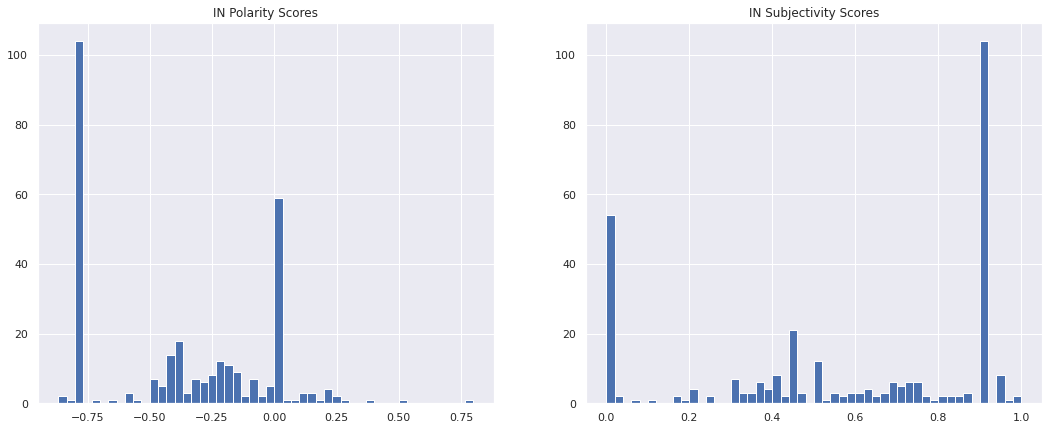

In [77]:
#IN Histograms of polarity and subjectivity
n_bins = 50
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(IN_Cleaned["polarity"], bins = n_bins)
ax1.set_title('IN Polarity Scores')
ax2.hist(IN_Cleaned["subjectivity"], bins = n_bins)
ax2.set_title('IN Subjectivity Scores')
plt.show()

[Text(0.5, 0, 'India Sentiment Result')]

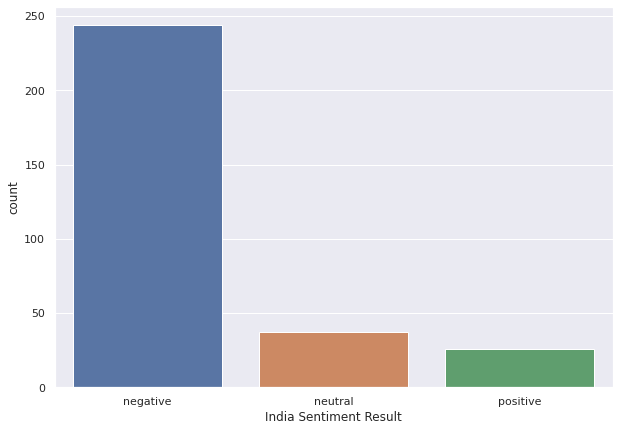

In [78]:
#IN Countplot of sentiment
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="sentiment", data=IN_Cleaned)
ax.set(xlabel='India Sentiment Result')

In [83]:
EU_Cleaned['region'] ='Europe'
NA_Cleaned['region'] ='North America'
AS_Cleaned['region'] ='Asia'
IN_Cleaned['region'] ='India'

In [85]:
#Concat regions into the same dataframe
frames = [EU_Cleaned, NA_Cleaned, AS_Cleaned, IN_Cleaned]
  
combine_df = pd.concat(frames)
display(combine_df)

,text,retweet_count,favorite_count,clean_tweet,Hash words,temp_list,polarity,subjectivity,neg,neu,pos,compound,sentiment,region
0,A women’s support group chooses not to signpos...,2.0,3.0,womens support group choose signpost vulnerabl...,No hashtags,"[womens, support, group, choose, signpost, vul...",-0.250000,0.300000,0.188,0.638,0.174,-0.3257,negative,Europe
1,You know the worst thing about the hate incide...,0.0,1.0,know bad thing hate incident experience last w...,No hashtags,"[know, bad, thing, hate, incident, experience,...",-0.500000,0.544444,0.339,0.607,0.054,-0.8402,negative,Europe
2,"@GeorgeHotchki14 @HJoyceGender @amscanlon Yup,...",0.0,0.0,yup misogyny hate crime scotland course,No hashtags,"[yup, misogyny, hate, crime, scotland, course]",-0.800000,0.900000,0.324,0.676,0.000,-0.8020,negative,Europe
3,@peacelove1967 @ScotCuthbertson Started report...,0.0,0.0,start report trust source switchboard amp lgbt...,No hashtags,"[start, report, trust, source, switchboard, am...",0.000000,0.000000,0.000,0.819,0.181,0.4767,positive,Europe
4,@peacelove1967 @ScotCuthbertson You talk of mu...,0.0,0.0,talk muddy water whilst deliberately misinterp...,No hashtags,"[talk, muddy, water, whilst, deliberately, mis...",-0.800000,0.900000,0.209,0.791,0.000,-0.5719,negative,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,@mmm_eat_glass @anumccartney This is a hate crime,0.0,4.0,hate crime,No hashtags,"[hate, crime]",-0.800000,0.900000,0.643,0.357,0.000,-0.8020,negative,India
303,New Jersey Police arrests Mohamed Hassanain in...,1.0,6.0,jersey police arrest mohamed hassanain hate cr...,No hashtags,"[jersey, police, arrest, mohamed, hassanain, h...",-0.216667,0.366667,0.361,0.536,0.104,-0.8020,negative,India
304,New Jersey Police arrests Mohamed Hassanain in...,0.0,0.0,jersey police arrest mohamed hassanain hate cr...,No hashtags,"[jersey, police, arrest, mohamed, hassanain, h...",-0.216667,0.366667,0.361,0.536,0.104,-0.8020,negative,India
305,@jahanzaib0126 @IndiaToday @gauravcsawant Indi...,0.0,0.0,indian public mock focus indian economy amp,No hashtags,"[indian, public, mock, focus, indian, economy,...",0.000000,0.066667,0.202,0.798,0.000,-0.5093,negative,India


***Combined Graphs***

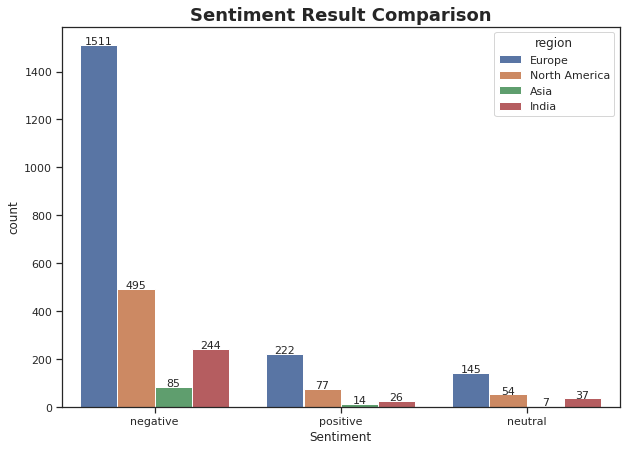

In [93]:
sns.set_style('ticks', rc={'figure.figsize':(10,15)})
ax = sns.countplot(x="sentiment", hue="region", data= combine_df)
ax.set_title('Sentiment Result Comparison',fontsize = 18, fontweight='bold' )
ax.set(xlabel='Sentiment')
#show count
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 11)

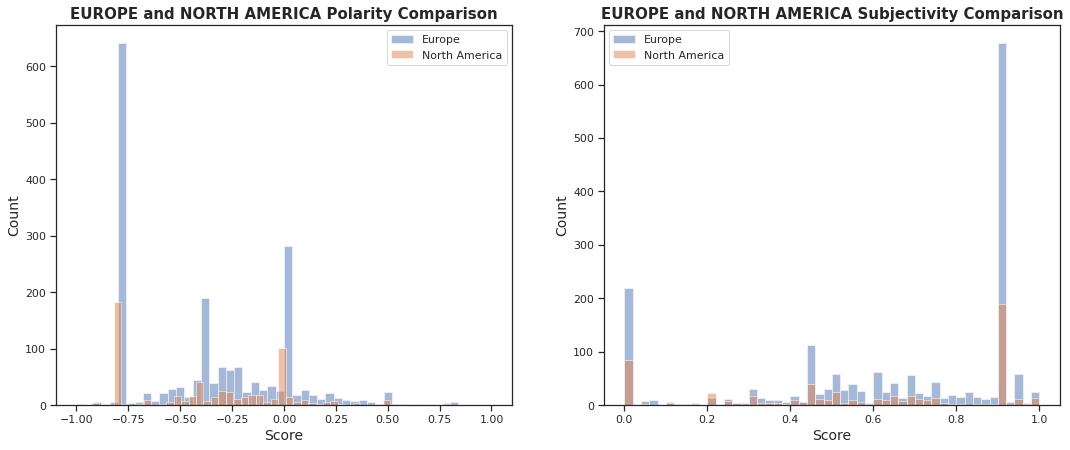

In [105]:
#EU NA
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(EU_Cleaned["polarity"], alpha=0.5, bins = n_bins, label="Europe")
ax1.hist(NA_Cleaned["polarity"], alpha=0.5, bins = n_bins, label="North America")
ax1.set_title("EUROPE and NORTH AMERICA Polarity Comparison", fontsize = 15, fontweight='bold')
ax1.set_xlabel("Score", size=14)
ax1.set_ylabel("Count", size=14)
ax1.legend(loc='upper right')

ax2.hist(EU_Cleaned["subjectivity"], alpha=0.5, bins = n_bins, label="Europe")
ax2.hist(NA_Cleaned["subjectivity"], alpha=0.5, bins = n_bins, label="North America")
ax2.set_title("EUROPE and NORTH AMERICA Subjectivity Comparison", fontsize = 15, fontweight='bold')
ax2.set_xlabel("Score", size=14)
ax2.set_ylabel("Count", size=14)
ax2.legend(loc='upper left')

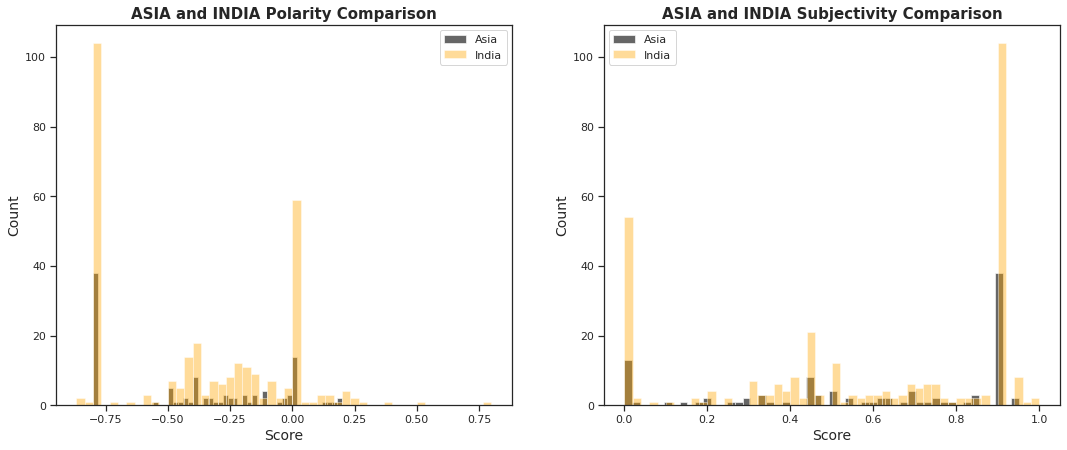

In [117]:
#AS IN
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.hist(AS_Cleaned["polarity"], alpha=0.6, bins = n_bins, label="Asia", color='black')
ax1.hist(IN_Cleaned["polarity"], alpha=0.4, bins = n_bins, label="India", color='orange')
ax1.set_title("ASIA and INDIA Polarity Comparison", fontsize = 15, fontweight='bold')
ax1.set_xlabel("Score", size=14)
ax1.set_ylabel("Count", size=14)
ax1.legend(loc='upper right')

ax2.hist(AS_Cleaned["subjectivity"], alpha=0.6, bins = n_bins, label="Asia", color='black')
ax2.hist(IN_Cleaned["subjectivity"], alpha=0.4, bins = n_bins, label="India", color='orange')
ax2.set_title("ASIA and INDIA Subjectivity Comparison", fontsize = 15, fontweight='bold')
ax2.set_xlabel("Score", size=14)
ax2.set_ylabel("Count", size=14)
ax2.legend(loc='upper left')